In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
import pickle

%matplotlib inline

In [2]:
data = pd.read_csv("spy.csv",index_col=0)

In [3]:
data.index = pd.to_datetime(data.index)

In [4]:
data.head(6)

,target_Open,target_High,target_Low,target_Change,target_%Chg,target_Volume,RSI,CMBO Last,CMBO Change,CMBO %Chg,...,TLT Put/Call Vol,TLT Options Vol,TLT Put/Call OI,TLT Total OI,VIX Change,VIX %Chg,GLD Imp Vol,GLD IV Rank,GLD Total OI,target_Last
2022-09-16,0.453751,0.450964,0.461522,-1.010351,-0.573600,0.341243,0.038276,0.245489,-0.742409,-0.485672,...,-0.628164,4.022133,-1.853642,2.802145,0.004608,-0.452381,0.486191,-0.251761,1.714926,0.474400
2022-09-15,0.585799,0.596086,0.561658,-0.993104,-0.573248,0.019037,0.038276,0.314367,-1.100919,-0.491054,...,-0.370484,-0.045796,-1.796094,2.824240,0.037345,-0.407447,0.748413,0.046011,1.476708,0.542672
2022-09-14,0.608406,0.599673,0.596789,0.296090,-0.113603,-0.035393,0.038276,0.416643,0.368435,0.110508,...,-0.745814,0.673913,-1.774365,2.732628,-0.461899,-0.474224,0.271255,-0.494704,1.420398,0.609747
2022-09-13,0.718596,0.702797,0.608799,-3.879777,-0.610945,0.755438,0.038276,0.382037,-4.344495,-0.539492,...,-0.162382,4.772434,-1.570298,2.923843,1.383669,1.595715,0.148742,-0.633337,1.319426,0.587289
2022-09-09,0.732220,0.768707,0.767035,1.313648,1.260397,-0.208827,0.038276,0.690989,1.518617,1.894279,...,-0.585549,0.570242,-1.501862,2.980586,-0.343227,-0.473355,-0.094135,-0.907038,1.273581,0.789410
2022-09-08,0.622180,0.669319,0.641828,0.533233,0.203474,-0.123021,0.038276,0.549235,0.642905,0.541073,...,-0.634913,1.374659,-1.461801,2.825307,-0.429162,-0.474384,-0.025356,-0.829029,1.249501,0.696284


In [5]:
data.columns

Index(['target_Open', 'target_High', 'target_Low', 'target_Change',
       'target_%Chg', 'target_Volume', 'RSI', 'CMBO Last', 'CMBO Change',
       'CMBO %Chg', 'DXY Open', 'DXY Change %', 'GLD Open', 'GLD Low',
       'GLD %Chg', 'GLD Volume', 'SPY Put/Call Vol', 'SPY Put/Call OI',
       'TLT Last', 'TLT Volume', 'TLT 1D IV Chg', 'TLT Put/Call Vol',
       'TLT Options Vol', 'TLT Put/Call OI', 'TLT Total OI', 'VIX Change',
       'VIX %Chg', 'GLD Imp Vol', 'GLD IV Rank', 'GLD Total OI',
       'target_Last'],
      dtype='object')

## FORECASTING

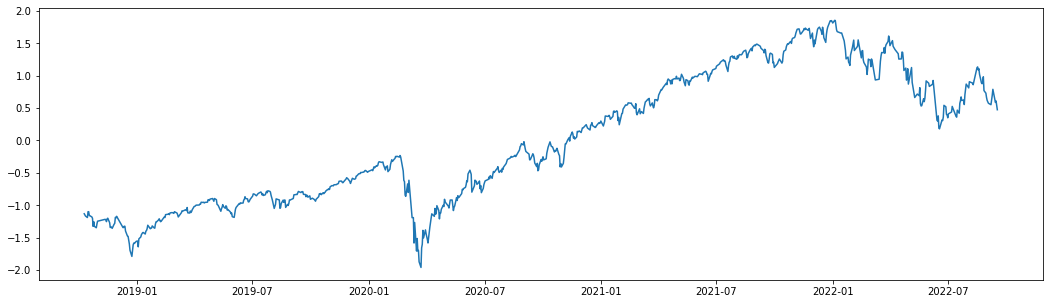

In [6]:
plt.figure(figsize=(18,5))
plt.plot(data["target_Last"])

In [7]:
from tensorflow.keras import losses,optimizers
from tensorflow.keras import metrics

2023-02-09 21:54:15.560997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 21:54:15.561024: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

In [9]:
dataset = data.values

In [10]:
dataset.shape

(857, 31)

In [13]:
sc = StandardScaler()
sc_dataset = sc.fit_transform(dataset)

pred_sc = StandardScaler()
pred_sc.fit_transform(dataset[:,-1:]) #for output values

array([[ 0.47440038],
       [ 0.54267233],
       [ 0.60974653],
       [ 0.58728865],
       [ 0.78940957],
       [ 0.69628423],
       [ 0.55225436],
       [ 0.5744128 ],
       [ 0.61843025],
       [ 0.66379516],
       [ 0.72997105],
       [ 0.77009579],
       [ 0.98269705],
       [ 0.89526104],
       [ 0.8754981 ],
       [ 0.89047002],
       [ 1.0220732 ],
       [ 1.10816173],
       [ 1.08959655],
       [ 1.13526091],
       [ 1.1226845 ],
       [ 0.86052618],
       [ 0.88508013],
       [ 0.902747  ],
       [ 0.90693914],
       [ 0.81126857],
       [ 0.87010821],
       [ 0.78147445],
       [ 0.70616569],
       [ 0.55420071],
       [ 0.6242693 ],
       [ 0.61708277],
       [ 0.67247888],
       [ 0.61229176],
       [ 0.57486196],
       [ 0.42035175],
       [ 0.46796246],
       [ 0.3598652 ],
       [ 0.37363936],
       [ 0.52575406],
       [ 0.43981525],
       [ 0.40972169],
       [ 0.34998373],
       [ 0.39624696],
       [ 0.40088826],
       [ 0

In [14]:
sc_dataset

array([[ 0.45375059,  0.45096418,  0.46152217, ..., -0.25176102,
         1.71492613,  0.47440038],
       [ 0.58579891,  0.59608563,  0.56165847, ...,  0.04601126,
         1.47670813,  0.54267233],
       [ 0.60840582,  0.59967256,  0.59678874, ..., -0.49470396,
         1.42039798,  0.60974653],
       ...,
       [-1.17200075, -1.18124107, -1.15702274, ...,  1.1301163 ,
        -0.65010279, -1.18987819],
       [-1.15373557, -1.1804938 , -1.18599771, ...,  0.95715875,
        -0.70600939, -1.16667172],
       [-1.00312263, -1.03372834, -1.10327642, ...,  0.71510734,
        -1.0653762 , -1.1314877 ]])

# TIME SERIES SHAPING

In [15]:
sc_dataset.shape

(857, 31)

In [16]:
sc_dataset[0:4]

array([[ 4.53750590e-01,  4.50964180e-01,  4.61522167e-01,
        -1.01035052e+00, -5.73599957e-01,  3.41243030e-01,
         3.82757359e-02,  2.45488592e-01, -7.42409155e-01,
        -4.85671650e-01,  3.24618898e+00,  3.10480438e-02,
        -6.72389517e-02, -4.72610992e-02,  3.73257853e-01,
        -4.78626847e-01,  1.44520526e-01, -1.59865646e-01,
        -2.04476585e+00,  7.73225107e-01,  4.61268996e-01,
        -6.28164044e-01,  4.02213344e+00, -1.85364150e+00,
         2.80214515e+00,  4.60786902e-03, -4.52380838e-01,
         4.86191172e-01, -2.51761017e-01,  1.71492613e+00,
         4.74400381e-01],
       [ 5.85798908e-01,  5.96085625e-01,  5.61658467e-01,
        -9.93103782e-01, -5.73247650e-01,  1.90367455e-02,
         3.82757359e-02,  3.14366631e-01, -1.10091905e+00,
        -4.91053718e-01,  3.20000460e+00,  1.62902224e-01,
         3.45798038e-02, -3.35533647e-02, -6.68593194e-01,
         6.84443314e-01, -1.72400194e-01, -4.55789310e-01,
        -1.98966543e+00, -4.02

In [17]:
trainsize = int(len(sc_dataset) * 0.85)

In [18]:
trainsize

728

In [19]:
train_data , test_data = sc_dataset[0:trainsize+1] , sc_dataset[trainsize+1:]

In [20]:
train_data.shape , test_data.shape

((729, 31), (128, 31))

In [21]:
rows = dataset.shape[0]
cols = dataset.shape[1]
r0 = train_data.shape[0]
r1 = test_data.shape[0]

In [22]:
rows,cols,r0,r1

(857, 31, 729, 128)

In [23]:
Xtrain = [] #trend to be analyzed
ytrain = [] #output for the given-trend

Xtest = []
ytest = []

# nFuture = 1   # Number of days we want top predict into the future
nPast = 2  # Number of past days we want to use to predict the future 

for i in range(nPast ,  r0):
    Xtrain.append(train_data[i - nPast : i , 0:cols])
    ytrain.append(train_data[i  : i + 1 , -1])
    
for i in range(nPast ,  r1):
    Xtest.append(test_data[i - nPast : i , 0:cols])
    ytest.append(test_data[i : i + 1 , -1])
    
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

Xtest = np.array(Xtest)
ytest = np.array(ytest)

In [24]:
Xtrain.shape,Xtest.shape

((727, 2, 31), (126, 2, 31))

In [25]:
724+123

847

In [26]:
Xtrain[0]

array([[ 0.45375059,  0.45096418,  0.46152217, -1.01035052, -0.57359996,
         0.34124303,  0.03827574,  0.24548859, -0.74240916, -0.48567165,
         3.24618898,  0.03104804, -0.06723895, -0.0472611 ,  0.37325785,
        -0.47862685,  0.14452053, -0.15986565, -2.04476585,  0.77322511,
         0.461269  , -0.62816404,  4.02213344, -1.8536415 ,  2.80214515,
         0.00460787, -0.45238084,  0.48619117, -0.25176102,  1.71492613,
         0.47440038],
       [ 0.58579891,  0.59608563,  0.56165847, -0.99310378, -0.57324765,
         0.01903675,  0.03827574,  0.31436663, -1.10091905, -0.49105372,
         3.2000046 ,  0.16290222,  0.0345798 , -0.03355336, -0.66859319,
         0.68444331, -0.17240019, -0.45578931, -1.98966543, -0.40215289,
        -0.16419484, -0.37048366, -0.04579608, -1.79609437,  2.82424023,
         0.03734523, -0.40744739,  0.74841278,  0.04601126,  1.47670813,
         0.54267233]])

In [27]:
ytrain[0]

array([0.60974653])

In [28]:
pred_sc.inverse_transform([ytrain[0]])

array([[0.60974653]])

# LSTM MODEL

In [29]:
model = Sequential()
model.add(LSTM(50, input_shape=( Xtrain.shape[1] , Xtrain.shape[2]) , return_sequences=True))
model.add(LSTM(20, return_sequences=True , activation="relu"))
model.add(Dropout(0.3))
model.add(LSTM(10, activation="relu" , return_sequences=False))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

2023-02-09 21:56:12.172104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 21:56:12.172138: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 21:56:12.172164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (huda): /proc/driver/nvidia/version does not exist
2023-02-09 21:56:12.173257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             16400     
                                                                 
 lstm_1 (LSTM)               (None, 2, 20)             5680      
                                                                 
 dropout (Dropout)           (None, 2, 20)             0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 23,331
Trainable params: 23,331
Non-trainable params: 0
_________________________________________________________________


In [31]:
opmz = optimizers.Adam(learning_rate=0.001)
# loss = losses.mean_squared_error

model.compile(optimizer = opmz , loss = "mae")

In [32]:
history = model.fit(Xtrain, ytrain, epochs=25 , batch_size=16, validation_split=0.1) #100e #32b#validation_split=0.2

Epoch 1/25
41/41 [==============================] - 5s 23ms/step - loss: 0.8037 - val_loss: 0.8282
Epoch 2/25
41/41 [==============================] - 0s 6ms/step - loss: 0.4359 - val_loss: 0.3083
Epoch 3/25
41/41 [==============================] - 0s 6ms/step - loss: 0.2220 - val_loss: 0.2376
Epoch 4/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1691 - val_loss: 0.1378
Epoch 5/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1631 - val_loss: 0.1150
Epoch 6/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1440 - val_loss: 0.1363
Epoch 7/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1429 - val_loss: 0.1732
Epoch 8/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1313 - val_loss: 0.1241
Epoch 9/25
41/41 [==============================] - 0s 6ms/step - loss: 0.1245 - val_loss: 0.1569
Epoch 10/25
41/41 [==============================] - 0s 7ms/step - loss: 0.1099 - val_loss: 0.1258
Epoch 11/25
41/41 

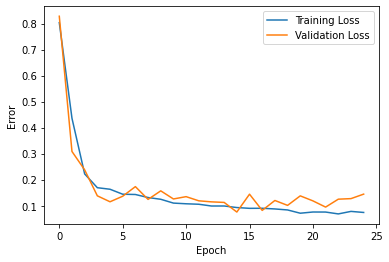

In [33]:
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(train_loss , label = "Training Loss")
plt.plot(validation_loss , label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

In [34]:
model.evaluate(Xtest,ytest)

4/4 [==============================] - 0s 3ms/step - loss: 0.3668


0.36680445075035095

In [35]:
y_predFuture = pred_sc.inverse_transform(model.predict(Xtest))
y_predTrain = pred_sc.inverse_transform(model.predict(Xtrain))

In [36]:
model_preds = np.vstack([y_predTrain,y_predFuture])

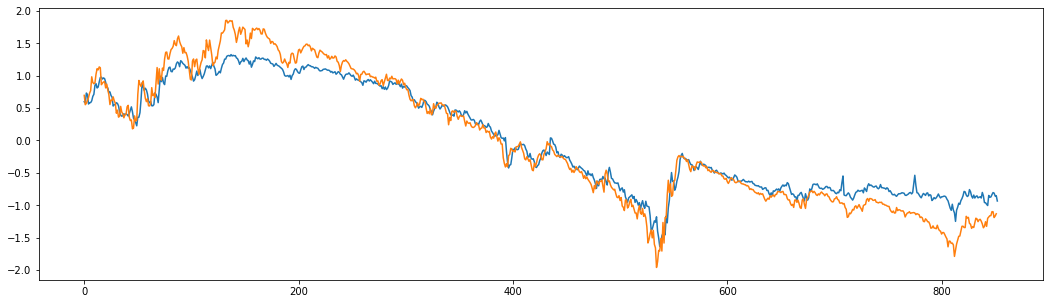

In [37]:
plt.figure(figsize=(18,5))
plt.plot(model_preds)
plt.plot(data.iloc[5:,-1].values)

In [38]:
data.shape

(857, 31)

In [39]:
model_preds.shape

(853, 1)